### 레이블 부족문제 다루기
| **특징**            | **Zero-shot**                              | **Few-shot**                              |
|:----------------------:|:--------------------------------------------:|:-------------------------------------------:|
| **레이블 수**       | 없음                                       | 매우 적음                                |
| **모델 접근 방식**  | 사전 학습된 모델의 일반화 능력 활용         | 제한된 데이터로 추가 학습 또는 조정       |
| **사용 사례**       | 완전히 새로운 태스크                        | 유사한 태스크지만 데이터가 적음          |

- 레이블 데이터 ⬇️, 레이블 안된 데이터 ⬆️ 일때
    - UDA(Unsupervised Data Augmentation) : 데이터 증강
    - UST(Uncertainty-aware Self-training) : 불확실성(softmax 또는 베이지안 분포로 파악)이 낮은 모델만 추출

### 데이터 셋 불러오고 전처리 하기

In [1]:
import pandas as pd

df = pd.read_json('dataset/github-issues-transformers.jsonl', lines=True)

print("df 크기 : ",df.shape)
print("df cols : ", [col for col in df.columns])
display("df labels : ",df.labels[2])

df 크기 :  (9930, 26)
df cols :  ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'body', 'performed_via_github_app', 'pull_request']


'df labels : '

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

In [2]:
cols = ["url", "id", "title" , "user" , "labels", "state" , "created_at", "body"]

df = df[cols]

In [3]:
# 필요한 밸류만 추출
df["labels"] = df["labels"].map(lambda x: [i["name"] for i in x])

In [4]:
# 각 글에 대하여 라벨 갯수
df["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [5]:
# 각 라벨 별 개수 확인
df["labels"].explode().value_counts().to_frame().head(8).T

labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [6]:
# 필용한 라벨만
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

In [7]:
df["labels"] = df["labels"].apply(lambda x : [label for label in x
                                              if label in label_map.keys()])

In [8]:
df["split"] = "unlabeled"
mask_over_zero = df["labels"].apply(lambda x:len(x)) > 0
# df.iloc[mask_over_zero, "split"] = "labeled"
df.loc[mask_over_zero, "split"] = "labeled"

In [9]:
df["labels"] = df["labels"].apply(lambda x: [label_map[i] for i in x
                                             if i in label_map.keys()] or x)

In [10]:
df['labels'].explode().value_counts().to_frame().T[label_map.values()]

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,examples,documentation
count,106,98,64,46,42,41,37,24,28


In [11]:
# check one sample
for col in ["title", "body", "labels"]:
    print(f"{col}:{df.iloc[26][col]}")
    print("-*-" * 50)

title:Add new CANINE model
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
body:# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy

In [12]:
df['text']= df.apply(lambda x : x['title'] + "\n\n" + x['body'] ,axis=1)

In [13]:
df.drop_duplicates(subset=['text'],inplace=True) # 중복 제거
len(df)

9743

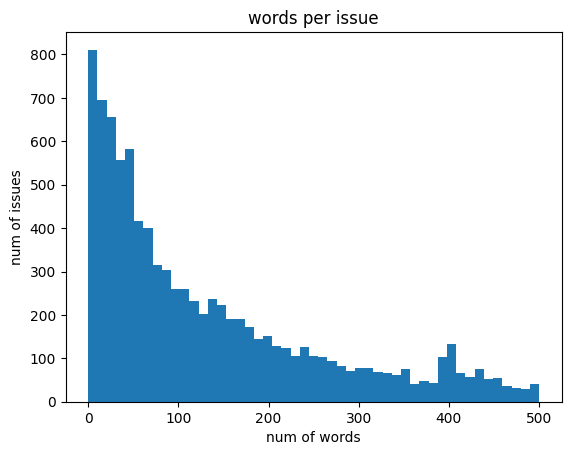

In [14]:
import numpy as np
import matplotlib.pyplot as plt

df["text"].str.split().apply(len).hist(bins=np.linspace(0,500,50), grid=False)
plt.title("words per issue")
plt.xlabel("num of words")
plt.ylabel("num of issues")
plt.show()

### 훈련 세트로 만들기

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df["labels"])

mlb. transform([["tokenization", "new model"], ["pytorch"]]) # 라벨의 이진화

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [16]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split

def balanced_train_test_split(df, test_size=0.5):
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    lbl = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_train_test_split(idx, lbl, test_size=test_size)
    
    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df[["text", "labels"]].reset_index(drop=True).copy()

In [17]:
df_clean

,text,labels
0,Potential incorrect application of layer norm ...,[]
1,Multi-GPU seq2seq example evaluation significa...,[]
2,[DeepSpeed] ZeRO stage 3 integration: getting ...,[]
3,Can't load model to estimater\n\nI was trying ...,[]
4,[LXMERT] Unclear what img_tensorize does with ...,[]
...,...,...
9738,DistilBERT\n\nPreparing the release for Distil...,[]
9739,Bert initialization\n\nWhen I train bert model...,[]
9740,UnicodeDecodeError: 'charmap' codec can't deco...,[]
9741,XLNet resize embedding size ERROR\n\n## ❓ Ques...,[]
